# Assignment 2 - Task 3: Evaluation & Discussion

This notebook loads the tuned models and artifacts, evaluates on the held-out test set, produces comparison tables and plots, and summarizes findings.


In [1]:
# Setup
from pathlib import Path
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

from google.colab import drive
drive.mount('/drive')

# Resolve notebooks root inside Google Drive robustly

def resolve_notebooks_root() -> Path:
    env_root = os.environ.get('ODL_NOTEBOOKS_ROOT')
    if env_root:
        root = Path(env_root)
        if (root / 'data/processed').exists():
            return root
    base = Path('/drive/My Drive')
    candidates = [
        base / 'Colab Notebooks' / 'notebooks',
        base / 'ODL-Assignment-test' / 'notebooks',
        base / 'ODL Assignment' / 'notebooks',
        base / 'notebooks',
    ]
    for cand in candidates:
        if (cand / 'data/processed').exists():
            return cand
    # Brute-force search as last resort (can take a bit if Drive is large)
    try:
        for p in base.rglob('notebooks'):
            if (p / 'data/processed').exists():
                return p
    except Exception:
        pass
    raise FileNotFoundError(
        'Could not locate notebooks root under Drive. Set env ODL_NOTEBOOKS_ROOT to the path that contains data/, artifacts/, models/ subfolders.'
    )

nb_root = resolve_notebooks_root()
print('Using notebooks root:', nb_root)

data_dir = nb_root / 'data' / 'processed'
artifacts_dir = nb_root / 'artifacts'
models_dir = nb_root / 'models' / 'tuned'

train_df = pd.read_csv(data_dir / 'train.csv', parse_dates=['Month'])
val_df = pd.read_csv(data_dir / 'val.csv', parse_dates=['Month'])
test_df = pd.read_csv(data_dir / 'test.csv', parse_dates=['Month'])
print('Test shape:', test_df.shape)


Mounted at /drive
Using notebooks root: /drive/My Drive/Colab Notebooks/notebooks
Test shape: (9918, 9)


In [2]:
# Recreate minimal features to align with tuning

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df['MonthSin'] = np.sin(2 * np.pi * df['MonthNum'] / 12.0)
    df['MonthCos'] = np.cos(2 * np.pi * df['MonthNum'] / 12.0)
    return df

for frame in (train_df, val_df, test_df):
    add_time_features(frame)

# Map Series ID to index (same method as tuning)
all_series_ids = pd.concat([
    train_df['Series ID'], val_df['Series ID'], test_df['Series ID']
], axis=0).unique()
series_ids = sorted(all_series_ids)
series_index = {sid: idx for idx, sid in enumerate(series_ids)}
denominator = max(len(series_ids) - 1, 1)
for frame in (train_df, val_df, test_df):
    frame['SeriesIndex'] = frame['Series ID'].map(series_index).astype('float32')
    frame['SeriesIndexNorm'] = frame['SeriesIndex'] / denominator

# Load scalers
turnover_scaler = joblib.load(artifacts_dir / 'turnover_scaler.joblib')
year_scaler = joblib.load(artifacts_dir / 'year_scaler.joblib')

for frame in (train_df, val_df, test_df):
    frame['TurnoverScaled'] = turnover_scaler.transform(frame[['Turnover']])
    frame['YearScaled'] = year_scaler.transform(frame[['Year']])


In [3]:
# DNN evaluation
preprocessor = joblib.load(artifacts_dir / 'dnn_preprocessor.joblib')

X_test_dnn = preprocessor.transform(test_df[['State','Industry','Series ID','Year','MonthNum','Quarter','MonthSin','MonthCos']]).astype(np.float32)
y_test = test_df['Turnover'].to_numpy(np.float32)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

# Try to load model; if absent, fall back to saved metrics JSON
try:
    dnn_model = keras.models.load_model(models_dir / 'dnn_tuned.keras')
except Exception:
    dnn_model = None

if dnn_model is not None:
    dnn_preds = dnn_model.predict(X_test_dnn, batch_size=256, verbose=0).squeeze()
    dnn_metrics = compute_metrics(y_test, dnn_preds)
    print('DNN tuned test metrics:', dnn_metrics)
else:
    dnn_metrics = None
    dnn_metrics_path = artifacts_dir / 'dnn_tuned_metrics.json'
    if dnn_metrics_path.exists():
        try:
            with open(dnn_metrics_path, 'r', encoding='utf-8') as f:
                obj = json.load(f)
            # Prefer explicit test_metrics if present
            if isinstance(obj, dict) and 'test_metrics' in obj:
                dnn_metrics = obj['test_metrics']
                print('Loaded DNN metrics from JSON artifacts (no model loaded).')
        except Exception as e:
            print('Failed to read DNN metrics JSON:', e)
    if dnn_metrics is None:
        print('No tuned DNN model or metrics found. Skip.')



DNN tuned test metrics: {'MSE': 7674.50439453125, 'RMSE': 87.60424872419858, 'MAE': 60.4646110534668, 'MAPE': 0.6079199314117432, 'R2': 0.9707192182540894}


In [4]:
# GRU evaluation (sequence)
WINDOW = 12
HORIZON = 1
seq_feature_cols = ['TurnoverScaled', 'MonthSin', 'MonthCos', 'YearScaled', 'SeriesIndexNorm']

# Build test arrays

def build_sequence_arrays(df: pd.DataFrame, feature_cols: list[str], target_col: str, window: int, horizon: int):
    sequences, targets, actuals = [], [], []
    for _, group in df.groupby('Series ID'):
        group = group.sort_values('Month')
        feat = group[feature_cols].to_numpy(np.float32)
        targ = group[target_col].to_numpy(np.float32)
        actual = group['Turnover'].to_numpy(np.float32)
        n = len(group) - window - horizon + 1
        if n <= 0:
            continue
        for i in range(n):
            sequences.append(feat[i:i+window])
            targets.append(targ[i+window:i+window+horizon])
            actuals.append(actual[i+window:i+window+horizon])
    if not sequences:
        return (
            np.empty((0, window, len(feature_cols)), dtype=np.float32),
            np.empty((0, horizon), dtype=np.float32),
            np.empty((0, horizon), dtype=np.float32),
        )
    return np.stack(sequences), np.stack(targets), np.stack(actuals)

X_seq_test, y_seq_test_scaled, y_seq_test_actual = build_sequence_arrays(test_df, seq_feature_cols, 'TurnoverScaled', WINDOW, HORIZON)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

try:
    gru_model = keras.models.load_model(models_dir / 'gru_tuned.keras')
except Exception:
    gru_model = None

if gru_model is not None and len(X_seq_test) > 0:
    preds_scaled = gru_model.predict(X_seq_test, batch_size=128, verbose=0)
    preds = turnover_scaler.inverse_transform(preds_scaled)
    y_true = y_seq_test_actual.squeeze(axis=-1)
    y_pred = preds.squeeze(axis=-1)

    gru_metrics = compute_metrics(y_true, y_pred)
    print('GRU tuned test metrics:', gru_metrics)
else:
    gru_metrics = None
    gru_metrics_path = artifacts_dir / 'gru_tuned_metrics.json'
    if gru_metrics_path.exists():
        try:
            with open(gru_metrics_path, 'r', encoding='utf-8') as f:
                obj = json.load(f)
            if isinstance(obj, dict) and 'test_metrics' in obj:
                gru_metrics = obj['test_metrics']
                print('Loaded GRU metrics from JSON artifacts (no model loaded).')
        except Exception as e:
            print('Failed to read GRU metrics JSON:', e)
    if gru_metrics is None:
        print('No tuned GRU model or metrics found. Skip.')


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


GRU tuned test metrics: {'MSE': 1094.508056640625, 'RMSE': 33.08335014233935, 'MAE': 12.855664253234863, 'MAPE': 0.10264773666858673, 'R2': 0.9959864020347595}


In [5]:
# Comparison table and basic plots
rows = []
if dnn_metrics is not None:
    rows.append({'Model': 'DNN Tuned', **dnn_metrics})
if gru_metrics is not None:
    rows.append({'Model': 'GRU Tuned', **gru_metrics})

if rows:
    comparison_df = pd.DataFrame(rows).set_index('Model')
    display(comparison_df)
else:
    print('No metrics available to compare. Ensure tuned models exist or metrics JSON files are present in', artifacts_dir)


,MSE,RMSE,MAE,MAPE,R2
Model,,,,,
DNN Tuned,7674.504395,87.604249,60.464611,0.607920,0.970719
GRU Tuned,1094.508057,33.083350,12.855664,0.102648,0.995986


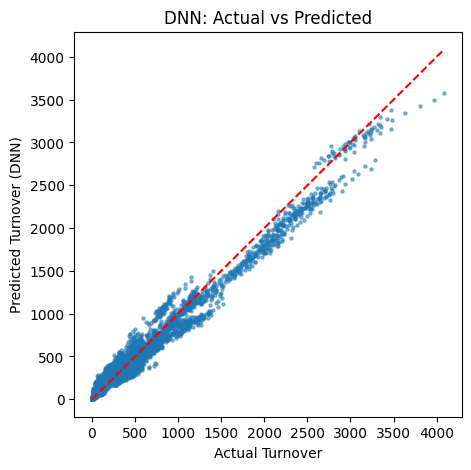

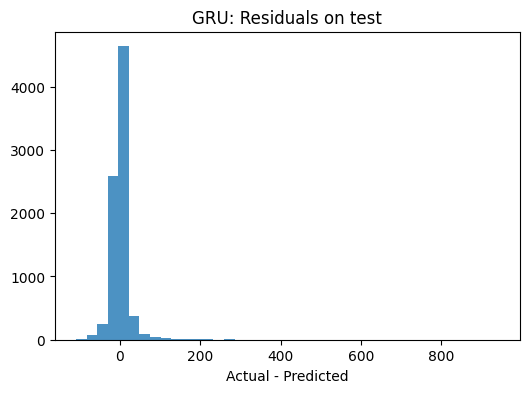

In [6]:
# Predicted vs Actual scatter (if DNN present)
if dnn_model is not None:
    plt.figure(figsize=(5,5))
    plt.scatter(y_test, dnn_preds, s=5, alpha=0.5)
    plt.xlabel('Actual Turnover')
    plt.ylabel('Predicted Turnover (DNN)')
    plt.title('DNN: Actual vs Predicted')
    lims = [min(y_test.min(), dnn_preds.min()), max(y_test.max(), dnn_preds.max())]
    plt.plot(lims, lims, 'r--')
    plt.show()

# GRU residuals histogram
if gru_model is not None and 'y_pred' in locals():
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=40, alpha=0.8)
    plt.title('GRU: Residuals on test')
    plt.xlabel('Actual - Predicted')
    plt.show()
